In [2]:
# 1. Import packages
import os,keras,cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import mlflow
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers 

In [3]:
# 2. Data loading

PATH = os.path.join('Cat_Breed')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset,validation_dataset = keras.utils.image_dataset_from_directory(PATH,shuffle=True,
                                                                            validation_split=0.3,
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,subset='both',
                                                                            seed=40)

Found 5499 files belonging to 11 classes.
Using 3850 files for training.
Using 1649 files for validation.


['Abyssinian', 'Bombay', 'Egyptian Mau', 'Exotic Shorthair', 'Himalayan', 'Maine Coon', 'Regdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Sphynx']


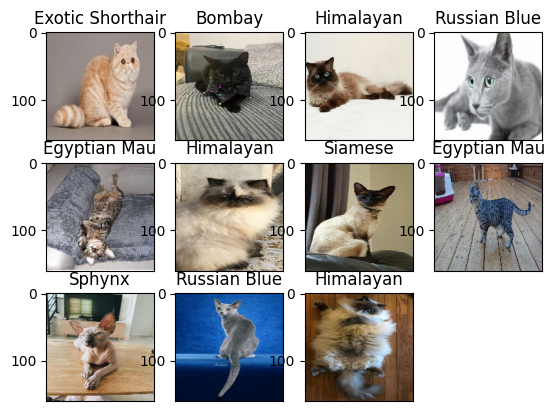

In [4]:
#3. Inspect some data samples from the dataset
class_names = train_dataset.class_names
print(class_names)
batch_1 = train_dataset.take(1)
for features,label in batch_1:
    for i in range(11):
        plt.subplot(3,4,i+1)
        plt.imshow(features[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.grid(False)
plt.show()

In [5]:
# 4. Split the validation dataset into 2 equal splits: for val and test
nBatches = validation_dataset.cardinality().numpy()
print(nBatches)
val_dataset = validation_dataset.take(nBatches*0.7)
test_dataset = validation_dataset.skip(nBatches//2)

52


In [6]:
# 5.Convert the val and test dataset back to PrefetchDataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# 6. Create a sequential model for augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip())
data_augmentation.add(layers.RandomRotation(factor=0.2))

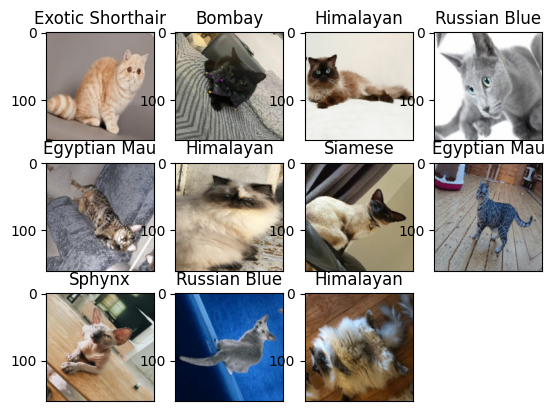

In [8]:
features_augmented = data_augmentation(features)
for i in range(11):
    plt.subplot(3,4,i+1)
    plt.imshow(features_augmented[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.xticks([])
    plt.grid(False)
plt.show()

In [9]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [10]:
# 7. Applu Transfer learning
#(A) Load in the pretrained model as feature extractor
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
# Freeze the entire feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
#(B) Construct the classifier 
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [12]:
#(C) Use functional API to connect all th layers together
#a. Begin with the input 
inputs = keras.Input(shape=IMG_SHAPE)
#b. Augmentation layers
x = data_augmentation(inputs)
#c.preprocessing layer
x = preprocess_input(x)
#d. Feature extractor
x = base_model(x)
#e.Classifier
x = global_avg(x)
outputs = output_layer(x)
#f. Create the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        14,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [13]:
#8. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
history = model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [14]:
#Include mlflow into workflow
mlflow.set_experiment('Cat Breed')

<Experiment: artifact_location='file:///d:/MAFA/Capstone_Project/mlruns/398812858354036590', creation_time=1741963313340, experiment_id='398812858354036590', last_update_time=1741963313340, lifecycle_stage='active', name='Cat Breed', tags={}>

In [15]:
#9.Proceed with the training
EPOCHS = 10
#train model,include the logging into mlflow
with mlflow.start_run() as run:
    mlflow_callback = mlflow.keras.MlflowCallback(run)
    run_id = run.info.run_id
    log_path = f"logs/{run_id}"
    ts = callbacks.TensorBoard(log_dir=log_path)
    history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[mlflow_callback,ts])
    mlflow.keras.save.log_model(model,artifact_path='model')    

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 57s 424ms/step - accuracy: 0.0954 - loss: 2.7250 - val_accuracy: 0.2951 - val_loss: 2.0636
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 415ms/step - accuracy: 0.3739 - loss: 1.8403 - val_accuracy: 0.5321 - val_loss: 1.5207
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 416ms/step - accuracy: 0.5695 - loss: 1.3956 - val_accuracy: 0.6632 - val_loss: 1.2206
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.6577 - loss: 1.1236 - val_accuracy: 0.7205 - val_loss: 1.0347
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 418ms/step - accuracy: 0.7028 - loss: 0.9709 - val_accuracy: 0.7517 - val_loss: 0.9123
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 422ms/step - accuracy: 0.7258 - loss: 0.8862 - val_accuracy: 0.7786 - val_loss: 0.8270
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.7624 - loss: 0.7796 - val_accuracy: 0.7995 - val_loss: 0.7610
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.7716 - loss: 0

2025/03/15 14:49:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/15 14:49:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [16]:
# 10. 2nd stage transfer learning
# (A) Unfreeze the base model
base_model.trainable = True
# (B) Free the earlier layers of the base model
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [17]:
# Recompile the model and train again
rmsprop = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rmsprop,loss=loss,metrics=['accuracy'])

In [18]:
history_first.epoch[-1]

9

In [19]:
# Run the second stage training
second_epochs = 10
total_epochs = EPOCHS + second_epochs
starting_epoch = history_first.epoch[-1] + 1
with mlflow.start_run() as run:
    mlflow_callback = mlflow.keras.MlflowCallback(run)
    run_id = run.info.run_id
    log_path = f"logs/{run_id}"
    ts = callbacks.TensorBoard(log_dir=log_path)
    history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=total_epochs,initial_epoch=starting_epoch,callbacks=[mlflow_callback,ts])
    mlflow.keras.save.log_model(model,artifact_path='model') 

Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 600ms/step - accuracy: 0.6692 - loss: 1.0284 - val_accuracy: 0.8368 - val_loss: 0.5562
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 72s 596ms/step - accuracy: 0.7660 - loss: 0.7702 - val_accuracy: 0.8594 - val_loss: 0.5035
Epoch 13/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 88s 725ms/step - accuracy: 0.8033 - loss: 0.6495 - val_accuracy: 0.8715 - val_loss: 0.4590
Epoch 14/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 668ms/step - accuracy: 0.8264 - loss: 0.5698 - val_accuracy: 0.8837 - val_loss: 0.4258
Epoch 15/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 675ms/step - accuracy: 0.8271 - loss: 0.5297 - val_accuracy: 0.8854 - val_loss: 0.3980
Epoch 16/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 74s 609ms/step - accuracy: 0.8564 - loss: 0.4519 - val_accuracy: 0.8932 - val_loss: 0.3711
Epoch 17/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 560ms/step - accuracy: 0.8553 - loss: 0.4458 - val_accuracy: 0.8941 - val_loss: 0.3460
Epoch 18/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 70s 577ms/step - accuracy: 0.8627 -

2025/03/15 15:02:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/15 15:02:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


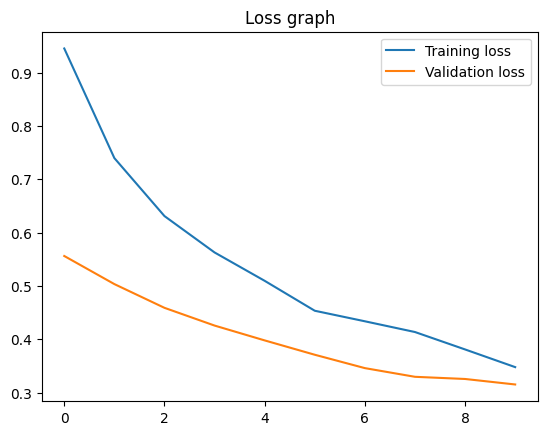

In [23]:
# Plot the graph loss and accuracy
plt.plot(history_first.history['loss'])
plt.plot(history_first.history['val_loss'])
plt.title("Loss graph")
plt.legend(['Training loss','Validation loss'])
plt.show()

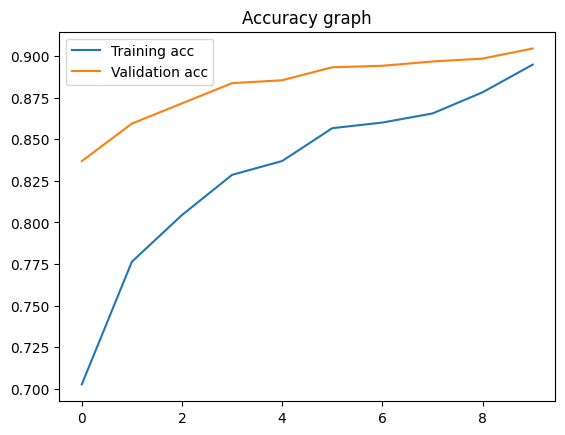

In [24]:
# Plot the accuracy graph
plt.plot(history_first.history['accuracy'])
plt.plot(history_first.history['val_accuracy'])
plt.title("Accuracy graph")
plt.legend(['Training acc','Validation acc'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
['Russian Blue', 'Russian Blue', 'Egyptian Mau', 'Maine Coon', 'Russian Blue', 'Sphynx', 'Maine Coon', 'Exotic Shorthair', 'Egyptian Mau', 'Siamese', 'Sphynx', 'Regdoll', 'Scottish Fold', 'Exotic Shorthair', 'Abyssinian', 'Maine Coon', 'Himalayan', 'Russian Blue', 'Bombay', 'Himalayan', 'Maine Coon', 'Russian Blue', 'Egyptian Mau', 'Maine Coon', 'Himalayan', 'Russian Blue', 'Scottish Fold', 'Maine Coon', 'Siamese', 'Russian Blue', 'Exotic Shorthair', 'Bombay']


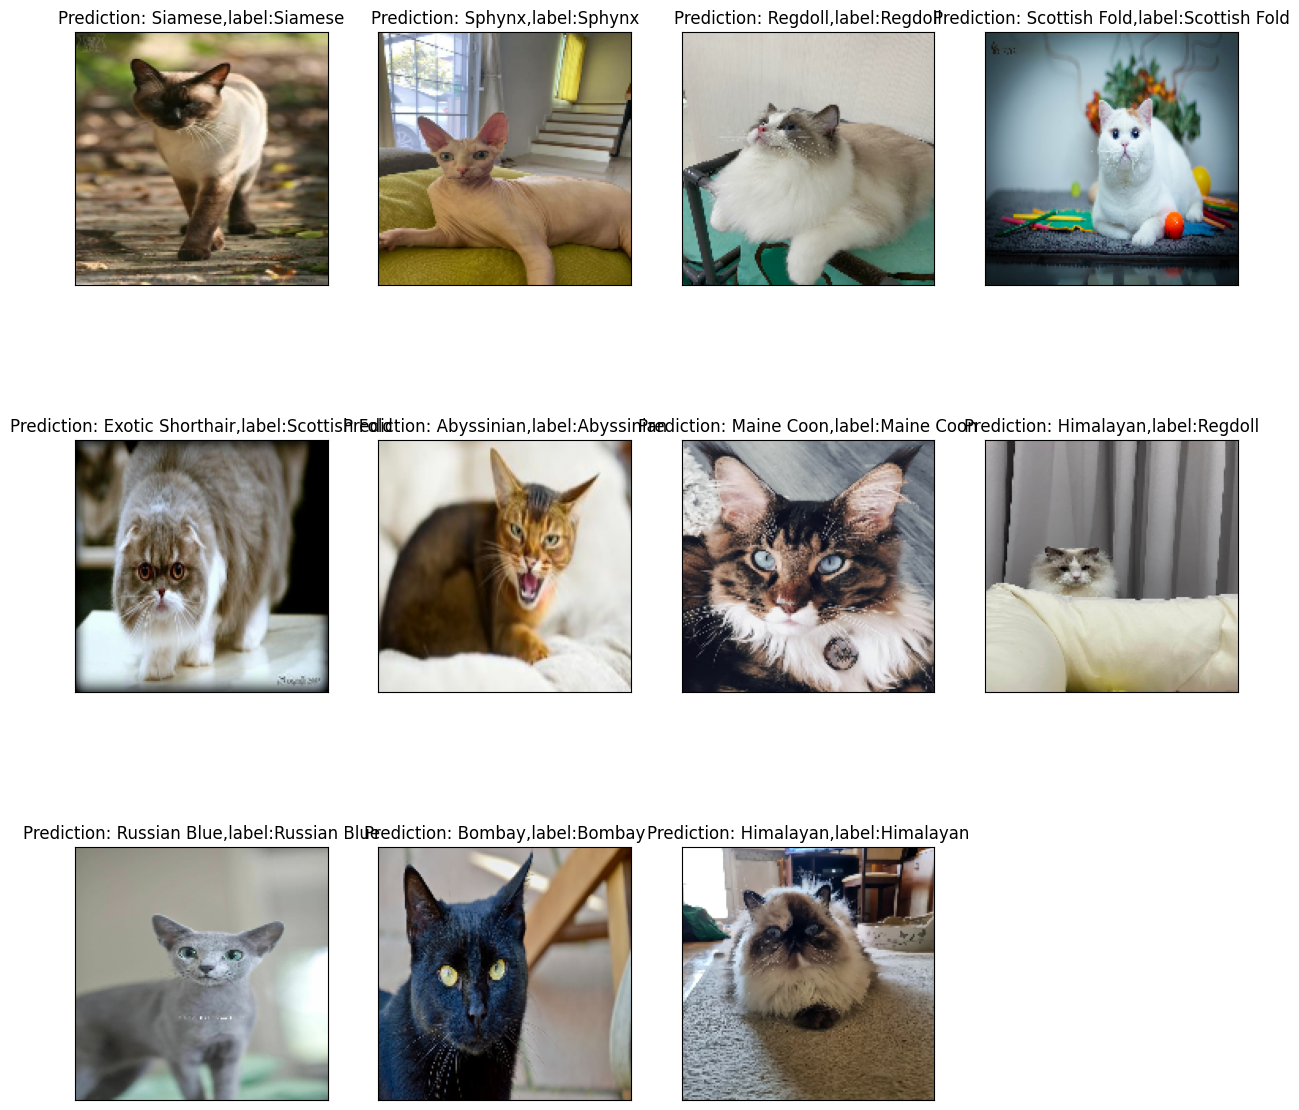

In [25]:
#Use the model to make prediction
for image_batch,label_batch in test_dataset.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(11):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i+9].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i+9]},label:{class_names[label_batch[i+9]]}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

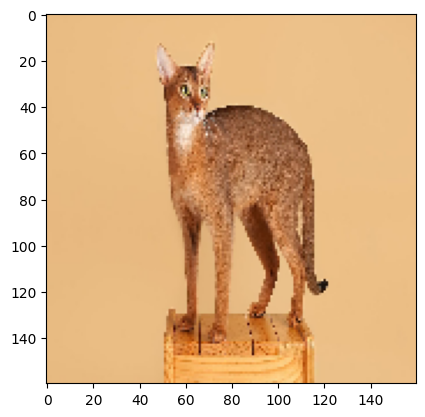

(160, 160, 3)
(1, 160, 160, 3)


In [26]:
#Use the model to predict with a random image
img = cv2.imread(filename="Cat.jpg",flags=cv2.IMREAD_COLOR_RGB)
#img = cv2.cvtColor(img,code=cv2.COLOR_BGR2BGR)
img = cv2.resize(img,dsize=(160,160))
plt.imshow(img)
plt.show()
print(img.shape)
img = np.expand_dims(img,axis=0)
print(img.shape)

In [27]:
prediction = model.predict(img)
class_names[np.argmax(prediction,axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


'Russian Blue'

In [28]:
model.save("model.keras")